In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:

kdd = pd.read_csv("kdd_FGM.csv")
nsl = pd.read_csv("nsl_FGM.csv")
ids = pd.read_csv("ids_FGM.csv")
ciciot = pd.read_csv("ciciot_FGM.csv")
kitsune = pd.read_csv("kitsune_FGM.csv")
credit = pd.read_csv("credit_FGM.csv")
ecg = pd.read_csv("ecg_FGM.csv")

in_kdd = kdd.loc[kdd['r1']==0.,'n1'].values[0]
in_ids = ids.loc[ids['r1']==0.,'n1'].values[0]
in_kitsune = kitsune.loc[kitsune['r1']==0.,'n1'].values[0]
in_ciciot = ciciot.loc[ciciot['r1']==0.,'n1'].values[0]
in_credit = credit.loc[credit['r1']==0.,'n1'].values[0]
in_ecg = ecg.loc[ecg['r1']==0.,'n1'].values[0]


kdd['ratio'] = kdd['n2']*(1-kdd['r2'])/in_kdd
ids['ratio'] = ids['n2']*(1-ids['r2'])/in_ids
ciciot['ratio'] = ciciot['n2']*(1-ciciot['r2'])/in_ciciot
kitsune['ratio'] = kitsune['n2']*(1-kitsune['r2'])/in_kitsune
credit['ratio'] = credit['n2']*(1-credit['r2'])/in_credit
nsl['ratio'] = nsl['n2']*(1-nsl['r2'])/in_kdd
ecg['ratio'] = ecg['n2']*(1-ecg['r2'])/in_ecg

kdd['name'] ='kdd'
nsl['name'] ='nsl'
credit['name'] ='credit'
ids['name'] = 'ids'
ciciot['name'] ='ciciot'
kitsune['name'] = 'kitsune'
ecg['name'] = 'ecg'
data = pd.concat([kdd, ids, ciciot,kitsune, credit, ecg], ignore_index=True)

In [3]:
#data = data[data['name']!='ids']
data = data[data['metric']=='sdc']
data.rename(columns={'name': 'dataset'}, inplace=True)
eps = 0.0000000000000001
data['improvement'] = 100*(data.r1-data.r2)/(data.r1+eps)
data['id'] = range(len(data))
data = data.sort_values(by=['dataset', 'r1'])
data.loc[data['dataset']=='kdd', 'id'] = range(11)
data.loc[data['dataset']=='ciciot', 'id'] = range(11)
data.loc[data['dataset']=='ids', 'id'] = range(11)
data.loc[data['dataset']=='kitsune', 'id'] = range(11)
data.loc[data['dataset']=='credit', 'id'] = range(11)
data.loc[data['dataset']=='ecg', 'id'] = range(11)
data.head(40)

,metric,n1,n2,r1,r2,ratio,dataset,improvement,id
22,sdc,127298,98690,0.000000,0.000000,0.775267,ciciot,0.000000,0
23,sdc,131650,102644,0.033057,0.026548,0.784922,ciciot,19.690871,1
24,sdc,136002,104325,0.063999,0.051100,0.777656,ciciot,20.155188,2
25,sdc,140354,107738,0.093022,0.074774,0.783060,ciciot,19.616817,3
26,sdc,144706,112033,0.120299,0.098328,0.793547,ciciot,18.263578,4
27,sdc,149058,113789,0.145983,0.117929,0.788465,ciciot,19.217689,5
28,sdc,153410,116463,0.170211,0.139658,0.787114,ciciot,17.949803,6
29,sdc,157762,120582,0.193101,0.160007,0.795676,ciciot,17.138027,7
30,sdc,162114,126453,0.214762,0.180628,0.813933,ciciot,15.893875,8
31,sdc,166466,126208,0.235291,0.197539,0.795590,ciciot,16.044923,9


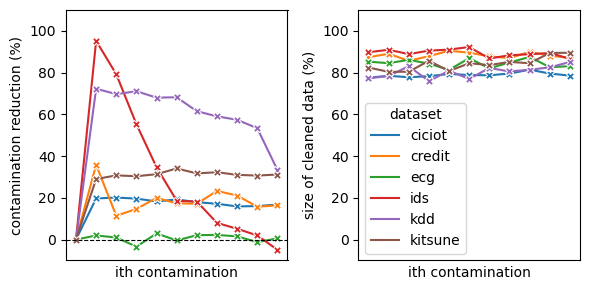

In [4]:
fig, ax = plt.subplots(ncols=2, figsize=(6, 3))
cond = data['dataset']=='ciciot'

sns.lineplot(data=data, x=data.id, y=data.improvement, hue='dataset', ax=ax[0], marker='X')
#ax.set_title(f'{subplot}'.upper())
ax[0].set_xlabel('ith contamination') 
ax[1].set_ylabel('size of cleaned data (%)')
sns.lineplot(data=data, x=data.id, y=100*data.ratio, hue='dataset', ax=ax[1], marker='X')
ax[1].set_xlabel('ith contamination') 
ax[0].set_ylabel('contamination reduction (%)')
ax[0].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
ax[0].legend().remove()
ax[0].set_xticks([])
ax[1].set_xticks([])
ax[0].set_ylim(-10, 110)
ax[1].set_ylim(-10, 110)
plt.tight_layout()
plt.savefig("cleaning_ratio.pdf")
plt.show()

In [5]:
df_1 = pd.read_csv("performances_kdd_AE.csv")
df_2 = pd.read_csv("performances_kdd_OC-SVM.csv")
df_3 = pd.read_csv("performances_kdd_LOF.csv")
df_4 = pd.read_csv("performances_kdd_IF.csv")
df_5 = pd.read_csv("performances_kdd_svdd.csv")
df_6 = pd.read_csv("performances_kdd_dsebm.csv")
#df_7 = pd.read_csv("performances_kdd_ALAD.csv")
#df_8 = pd.read_csv("performances_kdd_DAGMM.csv")
df_kdd = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6], axis=0, ignore_index=True)

In [6]:
df_1 = pd.read_csv("performances_kitsune_AE.csv")
df_2 = pd.read_csv("performances_kitsune_OC-SVM.csv")
df_3 = pd.read_csv("performances_kitsune_LOF.csv")
df_4 = pd.read_csv("performances_kitsune_IF.csv")
df_5 = pd.read_csv("performances_kitsune_svdd.csv")
#df_6 = pd.read_csv("performances_kitsune_DSEBM.csv")
#df_7 = pd.read_csv("performances_kitsune_ALAD.csv")
#df_8 = pd.read_csv("performances_kitsune_DAGMM.csv")
df_kitsune = pd.concat([df_1, df_2, df_3, df_4, df_5], axis=0, ignore_index=True)

In [7]:
df_1 = pd.read_csv("performances_ciciot_AE.csv")
df_2 = pd.read_csv("performances_ciciot_OC-SVM.csv")
df_3 = pd.read_csv("performances_ciciot_LOF.csv")
df_4 = pd.read_csv("performances_ciciot_IF.csv")
df_5 = pd.read_csv("performances_ciciot_svdd.csv")
#df_6 = pd.read_csv("performances_ciciot_DSEBM.csv")
#df_7 = pd.read_csv("performances_ciciot_ALAD.csv")
#df_8 = pd.read_csv("performances_ciciot_DAGMM.csv")
df_ciciot = pd.concat([df_1, df_2, df_3, df_4, df_5], axis=0, ignore_index=True)

In [8]:
df_1 = pd.read_csv("performances_ids_AE.csv")
df_2 = pd.read_csv("performances_ids_OC-SVM.csv")
df_3 = pd.read_csv("performances_ids_LOF.csv")
df_4 = pd.read_csv("performances_ids_IF.csv")
df_5 = pd.read_csv("performances_ids_svdd.csv")
df_6 = pd.read_csv("performances_ids_dsebm.csv")
#df_7 = pd.read_csv("performances_ids_ALAD.csv")
#df_8 = pd.read_csv("performances_ids_DAGMM.csv")
df_ids = pd.concat([df_1, df_2,  df_3, df_4, df_5, df_6], axis=0, ignore_index=True)

In [9]:
df_1 = pd.read_csv("performances_ecg_AE.csv")
df_2 = pd.read_csv("performances_ecg_OC-SVM.csv")
df_3 = pd.read_csv("performances_ecg_LOF.csv")
df_4 = pd.read_csv("performances_ecg_IF.csv")
df_5 = pd.read_csv("performances_ecg_svdd.csv")
df_6 = pd.read_csv("performances_ecg_dsebm.csv")
df_7 = pd.read_csv("performances_ecg_alad.csv")
#df_8 = pd.read_csv("performances_ecg_dagmm.csv")
df_ecg = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6, df_7], axis=0, ignore_index=True)

In [10]:
df_1 = pd.read_csv("performances_credit_AE.csv")
df_2 = pd.read_csv("performances_credit_OC-SVM.csv")
df_3 = pd.read_csv("performances_credit_LOF.csv")
df_4 = pd.read_csv("performances_credit_IF.csv")
df_5 = pd.read_csv("performances_credit_svdd.csv")
df_6 = pd.read_csv("performances_credit_dsebm.csv")
#df_7 = pd.read_csv("performances_credit_alad.csv")
#df_8 = pd.read_csv("performances_credit_DAGMM.csv")
df_credit = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6], axis=0, ignore_index=True)

In [11]:
df_perf = pd.concat([df_kdd, df_kitsune, df_ciciot, df_ecg, df_ids, df_credit], axis=0, ignore_index=True)
df_perf = df_perf.sort_values(by='dataset')

In [12]:
df_perf[df_perf["model"]=="Bopeto_svdd"].head()

,dataset,contamination,model,accuracy,precision,recall,f1
367,ciciot,0.254774,Bopeto_svdd,0.540319,0.701072,0.538368,0.609041
365,ciciot,0.235291,Bopeto_svdd,0.518502,0.682007,0.517125,0.588230
363,ciciot,0.214762,Bopeto_svdd,0.480435,0.649039,0.476358,0.549450
361,ciciot,0.193101,Bopeto_svdd,0.449543,0.621246,0.441480,0.516159
359,ciciot,0.170211,Bopeto_svdd,0.551853,0.710452,0.550530,0.620350


/tmp/ipykernel_849557/491522319.py:35: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


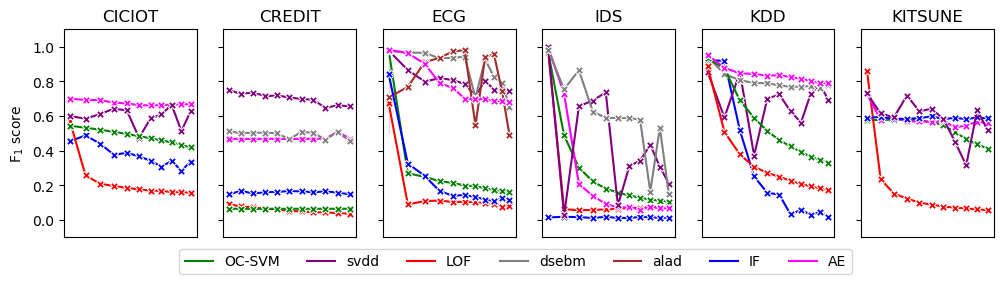

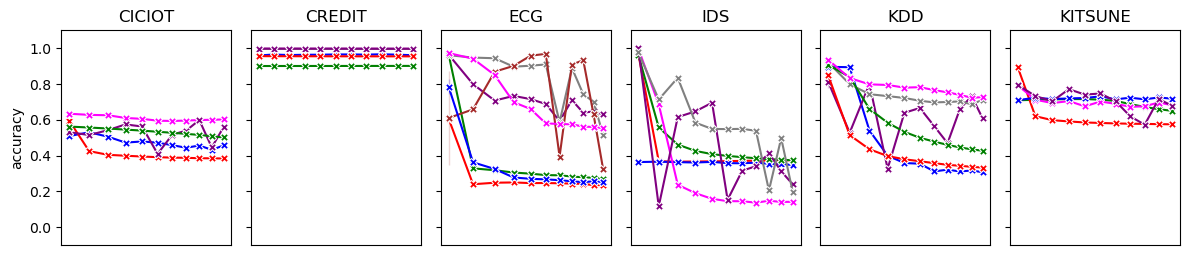

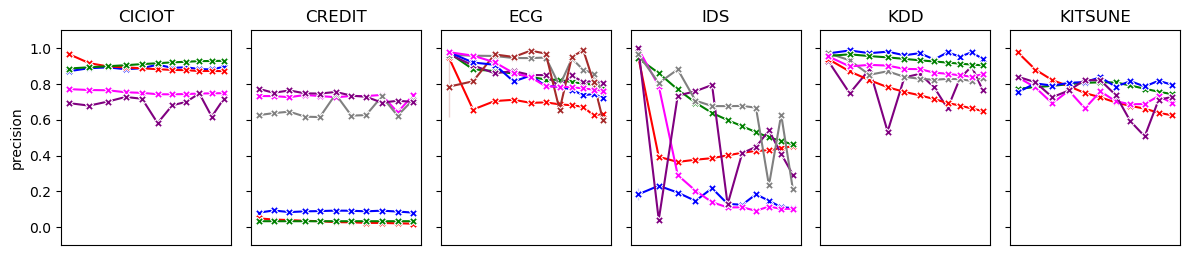

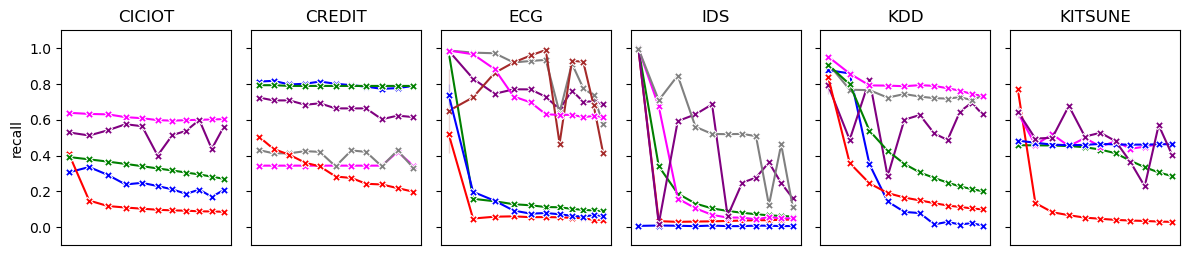

In [13]:
metrics = ["f1", "accuracy", "precision", "recall"]
color_palette_ = {
    "IF": "blue",
    "LOF": "red",
    "OC-SVM": "green",
    "AE": "magenta",
    "dsebm": "gray",
    "alad": "brown",
    "svdd": "purple",
    "dagmm": "cyan" 
}
for metric in metrics:
    degration = df_perf[~df_perf['model'].str.contains('Bopeto')]
    fig, axes = plt.subplots(ncols=6, figsize=(12, 2.7), sharey=True)
    for i, (ax, (subplot, df_group)) in enumerate(zip(axes, degration.groupby('dataset'))):
        sns.lineplot(data=df_group, x=df_group.contamination, y=metric, hue='model', ax=ax, marker='X', palette=color_palette_)
        ax.set_title(f'{subplot}'.upper())
        ax.set_xlabel('')
        ax.set_xticks([])
        if metric=="f1":
            ax.set_ylabel(r'F$_1$ score')
        else:
            ax.set_ylabel(metric)
        ax.set_ylim(-0.1, 1.1)
        if i != 2 or metric!="f1":
            ax.legend().remove()
        else:
            legend = ax.legend()
            if legend:
                for label in legend.get_texts():
                    label.set_fontsize('xx-small')
                    label.set_font('bold')
            ax.legend(loc='lower center', bbox_to_anchor=(1., -0.21), ncol=8)
            #ax.legend().get_frame().set_linewidth(1)
    plt.tight_layout()
    plt.savefig("degration_"+metric+".pdf")
    plt.show()

In [14]:
degration_perf = df_perf[~df_perf['model'].str.contains('Bopeto')]
degration_perf.groupby('dataset')['accuracy'].agg(['mean', 'std'])

,mean,std
dataset,,
ciciot,0.515763,0.075970
credit,0.968318,0.034866
ecg,0.582275,0.273541
ids,0.460943,0.255932
kdd,0.622890,0.203867
kitsune,0.695142,0.069678


In [15]:
degration_perf.groupby('model')['f1'].agg(['mean', 'std'])

,mean,std
model,,
AE,0.613412,0.247525
IF,0.292326,0.258831
LOF,0.220420,0.252135
OC-SVM,0.385683,0.262829
alad,0.804762,0.192092
dsebm,0.701401,0.212181
svdd,0.648597,0.187937


In [16]:
degration_perf.groupby('model')['precision'].agg(['mean', 'std'])

,mean,std
model,,
AE,0.715371,0.234660
IF,0.622614,0.360723
LOF,0.615458,0.310069
OC-SVM,0.697381,0.320848
alad,0.855372,0.152137
dsebm,0.775600,0.170964
svdd,0.730750,0.173223


In [17]:
degration_perf.groupby('model')['recall'].agg(['mean', 'std'])

,mean,std
model,,
AE,0.549726,0.258608
IF,0.333134,0.306565
LOF,0.211829,0.244442
OC-SVM,0.418349,0.286492
alad,0.765058,0.219029
dsebm,0.650693,0.239811
svdd,0.589443,0.198809


In [18]:
df_perf[df_perf['contamination']==0].head(10)

,dataset,contamination,model,accuracy,precision,recall,f1
324,ciciot,0.0,Bopeto_IF,0.615739,0.826745,0.534159,0.649000
323,ciciot,0.0,IF,0.511646,0.883257,0.306170,0.454718
322,ciciot,0.0,IF,0.506937,0.860755,0.308533,0.454245
347,ciciot,0.0,Bopeto_svdd,0.643638,0.788447,0.634383,0.703074
346,ciciot,0.0,svdd,0.529081,0.691702,0.526651,0.597997
345,ciciot,0.0,svdd,0.533337,0.694765,0.532078,0.602635
277,ciciot,0.0,OC-SVM,0.562402,0.886703,0.392123,0.543775
276,ciciot,0.0,OC-SVM,0.562402,0.886703,0.392123,0.543775
253,ciciot,0.0,AE,0.633277,0.770651,0.638655,0.698472
254,ciciot,0.0,AE,0.635030,0.772247,0.639964,0.699910


In [37]:
sub_df.head()

,dataset,contamination
271,ciciot,0.214762
338,ciciot,0.193101
336,ciciot,0.170211
334,ciciot,0.145983
332,ciciot,0.120299
...,...,...
180,kitsune,0.119587
167,kitsune,0.029293
182,kitsune,0.131133
184,kitsune,0.000000


In [38]:
sub_df = df_perf[['dataset', 'contamination']].drop_duplicates().groupby("dataset")['contamination'].apply(lambda x: sorted(x)).to_dict()
sub_df

{'ciciot': [0.0,
  0.0330573490315229,
  0.06399905883737,
  0.0930219302620516,
  0.1202990891877323,
  0.1459834426867393,
  0.1702105469004628,
  0.1931010002408691,
  0.2147624511146477,
  0.2352912907140197,
  0.2547740870400075],
 'credit': [0.0,
  0.0001165413846781,
  0.0002413770142495,
  0.0003661814762106,
  0.0004826375308929,
  0.0006073817685625,
  0.0007320948728401,
  0.0008484656912083,
  0.0009731186373012,
  0.00109774048417,
  0.0012223312434517],
 'ecg': [0.0,
  0.0652173913043478,
  0.1230661040787623,
  0.1736249171636845,
  0.219160926737633,
  0.259501187648456,
  0.29627539503386,
  0.3292092522861753,
  0.3595274781715459,
  0.3869223205506391,
  0.4123468426013195],
 'ids': [0.0,
  0.0356109572176054,
  0.0687728475049781,
  0.0997299161015975,
  0.1287010323612221,
  0.1558599880112882,
  0.181376999497064,
  0.2054016357065872,
  0.2280515896968427,
  0.2494460613464602,
  0.2696908778370189],
 'kdd': [0.0,
  0.0442997416020671,
  0.0848591618994833,
  0.1

In [19]:
def sort_group(group):
    return group.sort_values(by='dataset')

In [20]:
df_perf.head()

,dataset,contamination,model,accuracy,precision,recall,f1
271,ciciot,0.214762,Bopeto_AE,0.662342,0.790481,0.669833,0.725173
339,ciciot,0.214762,IF,0.456532,0.883562,0.210582,0.340106
338,ciciot,0.193101,Bopeto_IF,0.584685,0.848969,0.456787,0.593983
337,ciciot,0.193101,IF,0.444084,0.893647,0.186285,0.308303
336,ciciot,0.170211,Bopeto_IF,0.579734,0.852293,0.445243,0.584921


In [21]:
models = ["AE", "OC-SVM", "LOF", "IF", "svdd", "alad", "dsebm", "dagmm"]
names = ["CICIOT", "CREDIT", "ECG", "IDS", "KDD", "KITSUNE"]

In [22]:
def get_diff(model, dataset):
    n_db = pd.DataFrame([])
    ds = df_perf[(df_perf["dataset"]==dataset) & (df_perf["model"]==model)]
    ds_b = df_perf[(df_perf["dataset"]==dataset) & (df_perf["model"]=="Bopeto_"+model)]
    contamination = np.unique(ds["contamination"].values)
    diff_acc = []
    diff_f1 = []
    diff_prec = []
    diff_rec = []
    for c in contamination:
        acc = ds_b.loc[ds_b['contamination']==c, "accuracy"].values[0]
        acc -= ds.loc[ds['contamination']==c, "accuracy"].values[0]
        diff_acc.append(acc)
        f1 = ds_b.loc[ds_b['contamination']==c, "f1"].values[0]
        f1 -= ds.loc[ds['contamination']==c, "f1"].values[0]
        diff_f1.append(f1)
        prec = ds_b.loc[ds_b['contamination']==c, "precision"].values[0]
        prec -= ds.loc[ds['contamination']==c, "precision"].values[0]
        diff_prec.append(prec)
        rec = ds_b.loc[ds_b['contamination']==c, "recall"].values[0]
        rec -= ds.loc[ds['contamination']==c, "recall"].values[0]
        diff_rec.append(rec)
    n_db["accuracy"] = diff_acc
    n_db["precision"] = diff_prec
    n_db["f1"] = diff_f1
    n_db["recall"] = diff_rec
    n_db["contamination"] = contamination
    n_db["dataset"]=dataset
    n_db["model"] = model
    n_db["id"]=range(len(contamination))
    return n_db
    

In [23]:
get_diff("svdd", "ecg")

,accuracy,precision,f1,recall,contamination,dataset,model,id
0,-0.009052,-0.001522,-0.005866,-0.010267,0.000000,ecg,svdd,0
1,-0.058040,-0.033715,-0.040447,-0.045859,0.065217,ecg,svdd,1
2,0.160277,0.072715,0.114667,0.149213,0.123066,ecg,svdd,2
3,-0.105964,-0.062939,-0.077876,-0.088296,0.173625,ecg,svdd,3
4,-0.031416,-0.012334,-0.024219,-0.033539,0.219161,ecg,svdd,4
5,0.020234,0.004973,0.016647,0.025325,0.259501,ecg,svdd,5
6,0.075080,0.042766,0.057072,0.067077,0.296275,ecg,svdd,6
7,-0.107029,-0.057612,-0.080883,-0.097878,0.329209,ecg,svdd,7
8,-0.024494,-0.013025,-0.019040,-0.023272,0.359527,ecg,svdd,8
9,-0.029819,-0.018465,-0.022168,-0.024641,0.386922,ecg,svdd,9


In [24]:
difference = pd.DataFrame([])
for d_name in names:
    for m_name in models:
        difference = pd.concat([difference, get_diff(m_name, d_name.lower())], ignore_index=True)

In [25]:
difference.tail()

,accuracy,precision,f1,recall,contamination,dataset,model,id
380,-0.050074,-0.059321,-0.105145,-0.112858,0.083032,kitsune,svdd,6
381,0.143886,0.244629,0.217062,0.191817,0.095550,kitsune,svdd,7
382,0.196149,0.335829,0.364008,0.339927,0.107730,kitsune,svdd,8
383,-0.031435,0.026619,-0.103706,-0.157467,0.119587,kitsune,svdd,9
384,0.087952,0.115299,0.155563,0.158575,0.131133,kitsune,svdd,10


/tmp/ipykernel_849557/3773657058.py:33: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


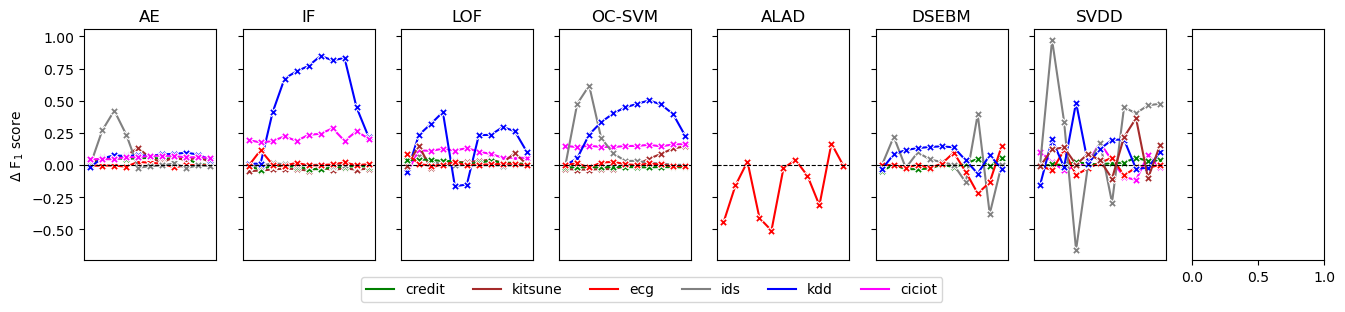

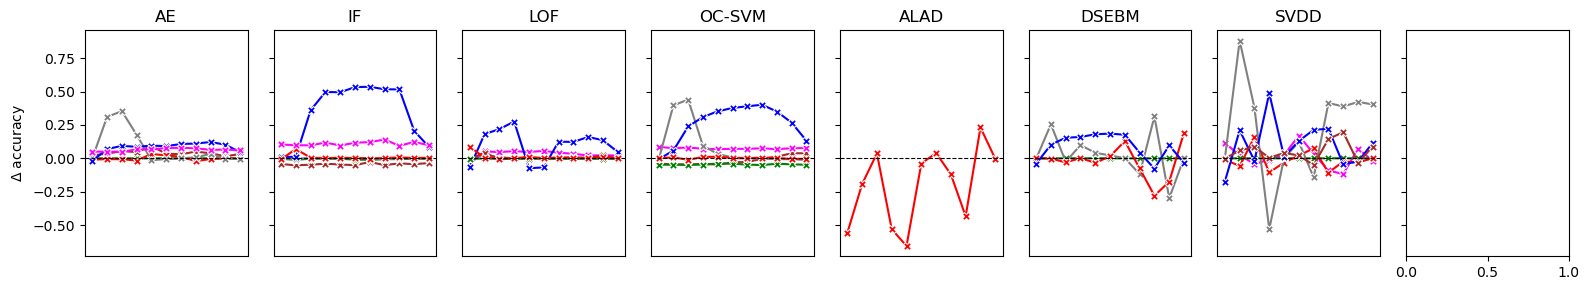

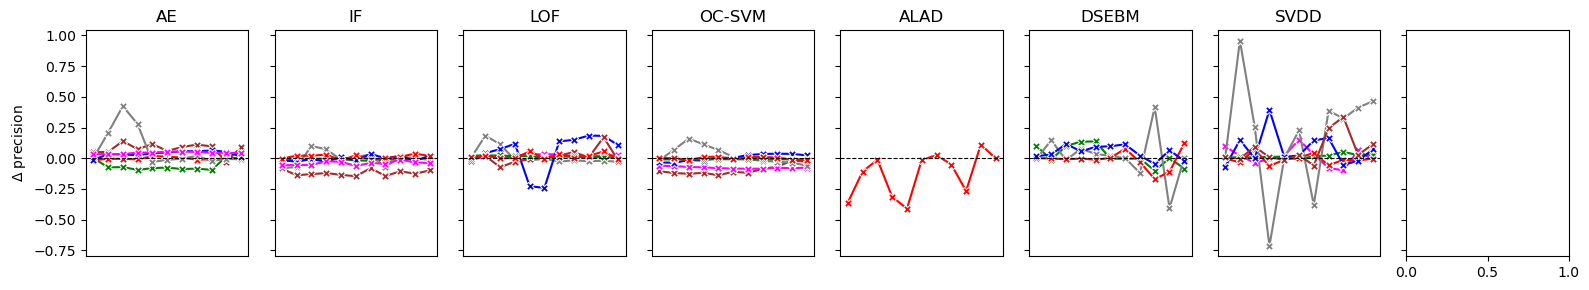

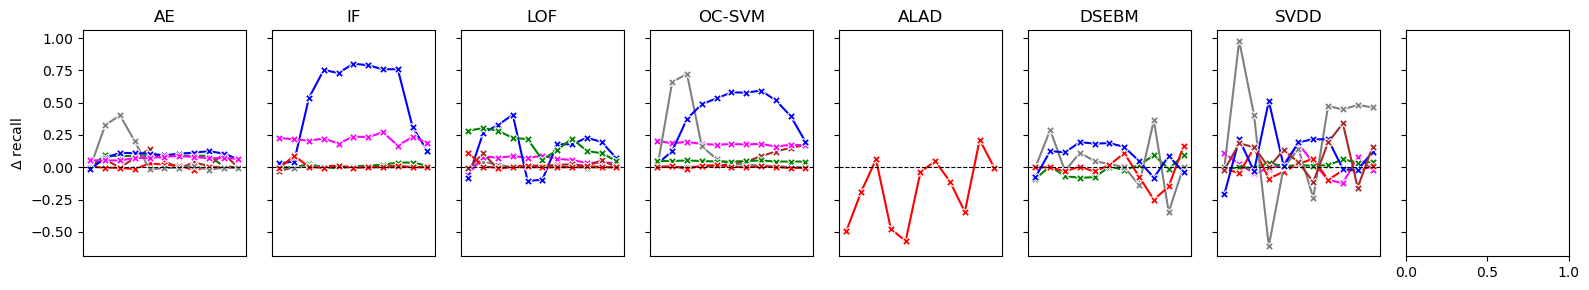

In [26]:
markers = ['o', 's', 'D', '^', 'v', '>', '<', 'x', '+', '*']
color_palette = {
    "kdd": "blue",
    "ecg": "red",
    "credit": "green",
    "ciciot": "magenta",
    "ids": "gray",
    "kitsune": "brown"  
}
for metric in metrics:
    robustness = difference.sort_values(by='contamination')
    fig, axes = plt.subplots(ncols=8, figsize=(16, 3), sharey=True)
    for i, (ax, (subplot, df_group)) in enumerate(zip(axes, robustness.groupby('model'))):
        sns.lineplot(data=df_group, x=df_group.id, y=metric, hue='dataset', ax=ax, marker='X', palette=color_palette)
        ax.set_title(f'{subplot}'.upper())
        ax.set_xlabel('')
        ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
        ax.set_xticks([])
        if metric=="f1":
            ax.set_ylabel(r'$\Delta$ F$_1$ score')
        else:    
            ax.set_ylabel(r'$\Delta$ {}'.format(metric))

        if i != 0 or metric!="f1":
            ax.legend().remove()
        else:
            legend = ax.legend()
            if legend:
                for label in legend.get_texts():
                    label.set_fontsize('xx-small')
                    label.set_font('bold')
                ax.legend(loc='lower center', bbox_to_anchor=(4.3, -0.21), ncol=6)
    plt.tight_layout()
    plt.savefig(metric+"_difference.pdf")
    plt.show()

In [631]:
df_perf.groupby(['model', 'dataset'])['precision'].agg(['mean', 'std'])

mean       std
model         dataset                    
AE            ciciot   0.754431  0.011126
              credit   0.725752  0.026854
              ecg      0.849877  0.086603
              ids      0.337672  0.363391
              kdd      0.887664  0.038243
              kitsune  0.736833  0.059425
Bopeto_AE     ciciot   0.796570  0.004269
              credit   0.665483  0.034310
              ecg      0.836410  0.077161
              ids      0.354564  0.376398
              kdd      0.918276  0.021407
              kitsune  0.804213  0.044780
Bopeto_IF     ciciot   0.848929  0.012871
              credit   0.077764  0.005020
              ecg      0.831514  0.081514
              ids      0.162977  0.057289
              kdd      0.963128  0.009003
              kitsune  0.681047  0.014174
Bopeto_LOF    ciciot   0.911316  0.019623
              credit   0.045518  0.015752
              ecg      0.718401  0.085709
              ids      0.470992  0.169129
              kdd      0.800688  0.149797
              kitsune  0.762340  0.101159
Bopeto_OC-SVM ciciot   0.836750  0.009571
              credit   0.024591  0.000573
              ecg      0.841967  0.056300
              kdd      0.939292  0.010839
              kitsune  0.690596  0.024685
IF            ciciot   0.887487  0.011224
              credit   0.088008  0.005138
              ecg      0.832959  0.092066
              ids      0.163817  0.043662
              kdd      0.966777  0.015735
              kitsune  0.796635  0.024825
LOF           ciciot   0.898843  0.034136
              credit   0.033158  0.010417
              ecg      0.722298  0.110287
              ids      0.499213  0.212252
              kdd      0.770828  0.102030
              kitsune  0.768411  0.122894
OC-SVM        ciciot   0.910907  0.016261
              credit   0.033665  0.000056
              ecg      0.853495  0.064668
              kdd      0.935951  0.021234
              kitsune  0.784222  0.020931

/tmp/ipykernel_278451/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


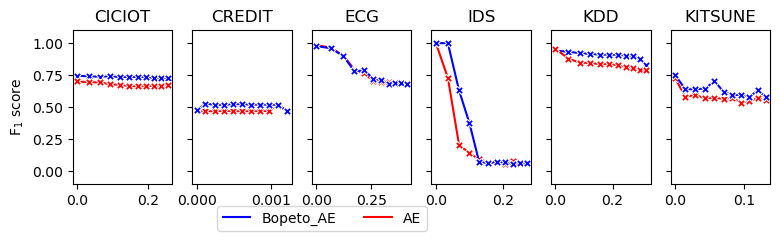

/tmp/ipykernel_278451/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


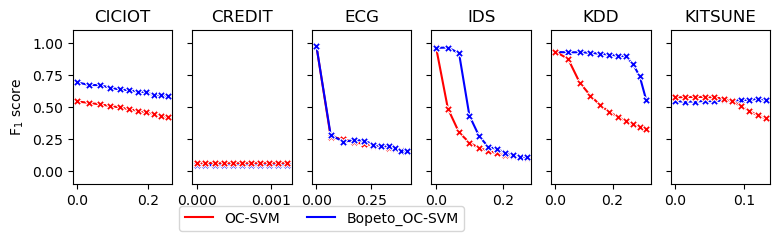

/tmp/ipykernel_278451/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


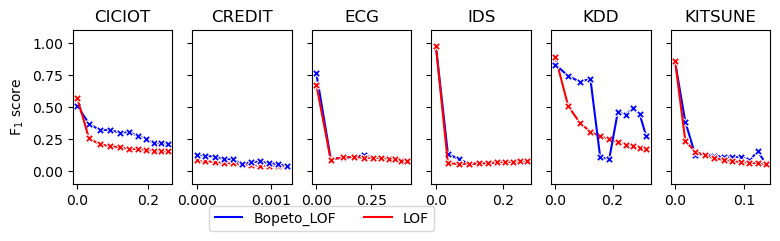

/tmp/ipykernel_278451/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


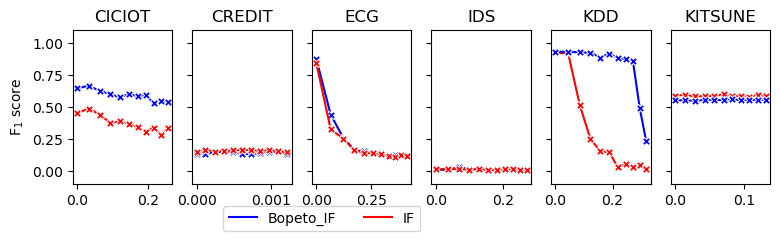

/tmp/ipykernel_278451/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


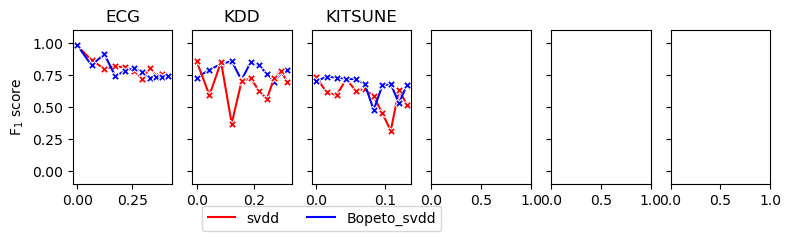

/tmp/ipykernel_278451/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


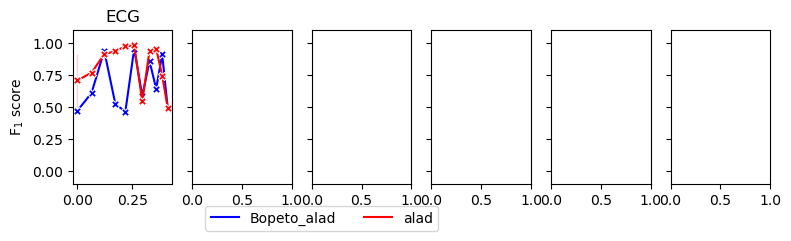

/tmp/ipykernel_278451/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


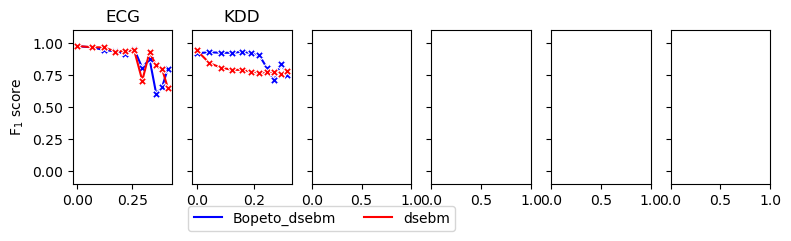

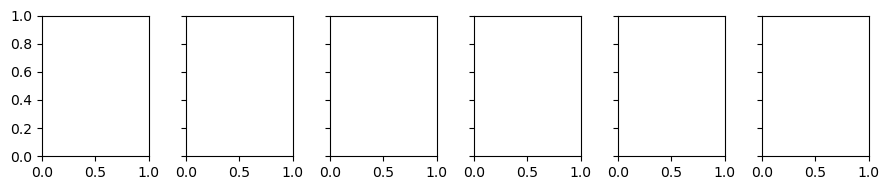

/tmp/ipykernel_278451/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


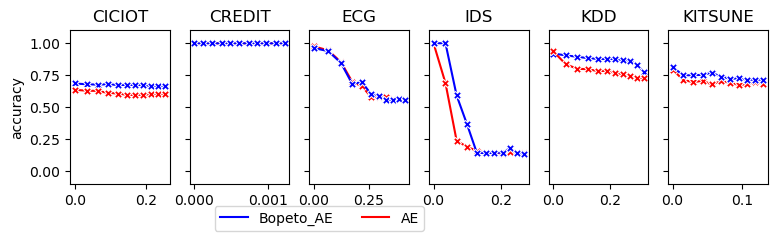

/tmp/ipykernel_278451/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


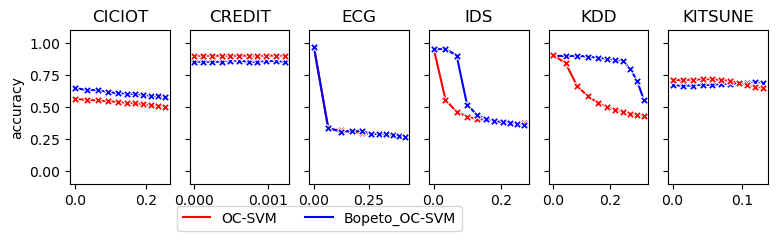

/tmp/ipykernel_278451/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


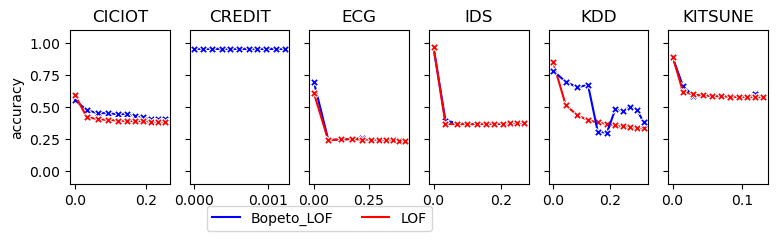

/tmp/ipykernel_278451/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


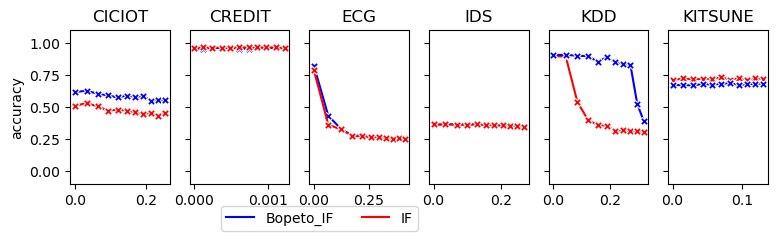

/tmp/ipykernel_278451/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


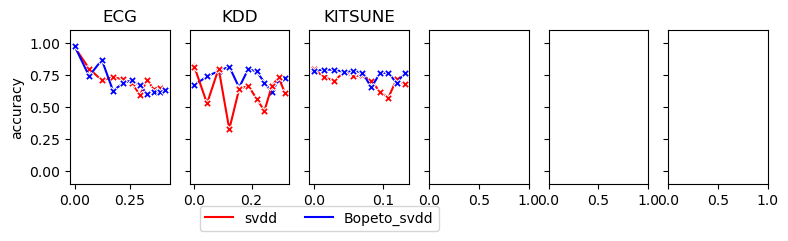

/tmp/ipykernel_278451/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


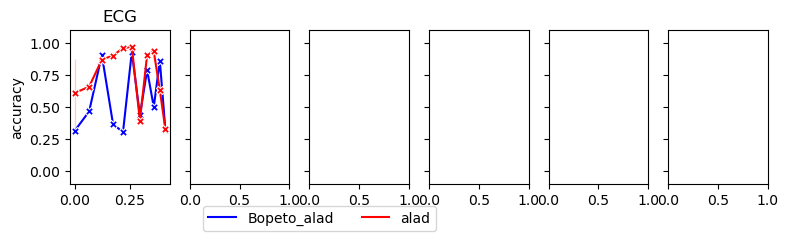

/tmp/ipykernel_278451/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


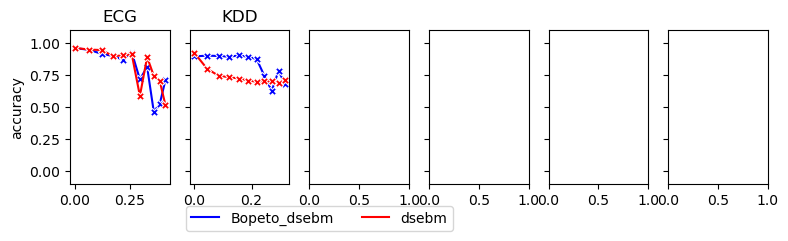

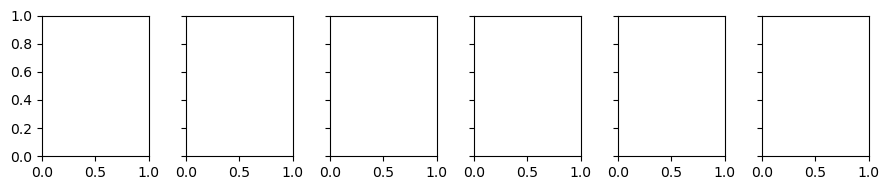

/tmp/ipykernel_278451/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


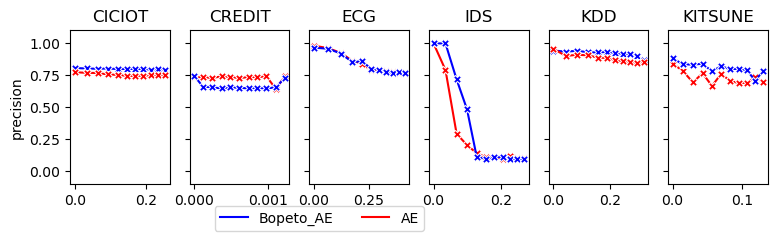

/tmp/ipykernel_278451/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


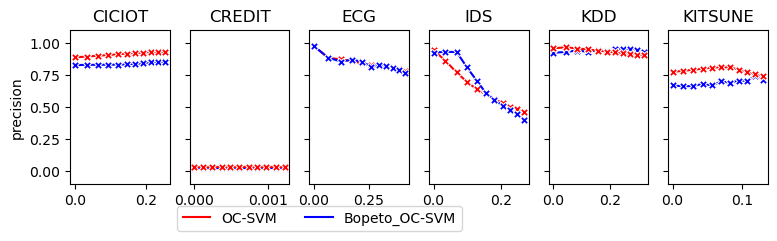

/tmp/ipykernel_278451/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


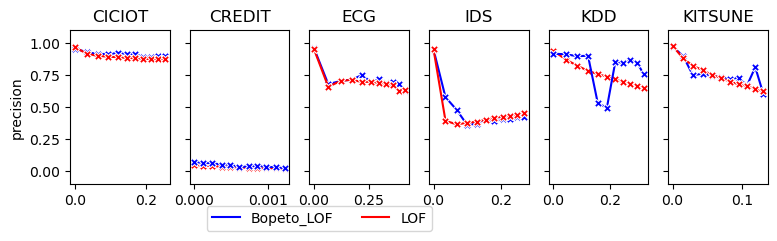

/tmp/ipykernel_278451/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


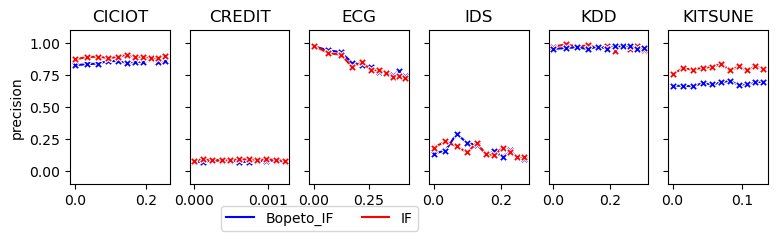

/tmp/ipykernel_278451/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


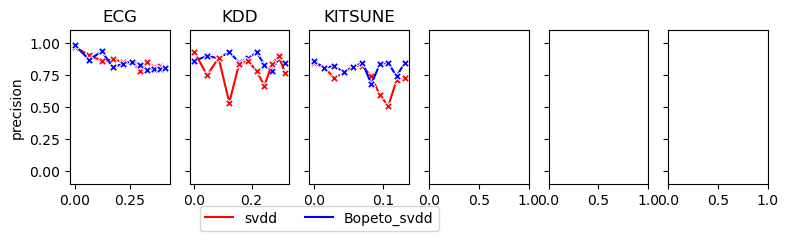

/tmp/ipykernel_278451/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


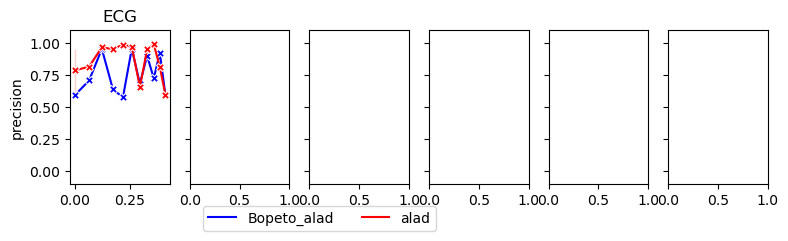

/tmp/ipykernel_278451/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


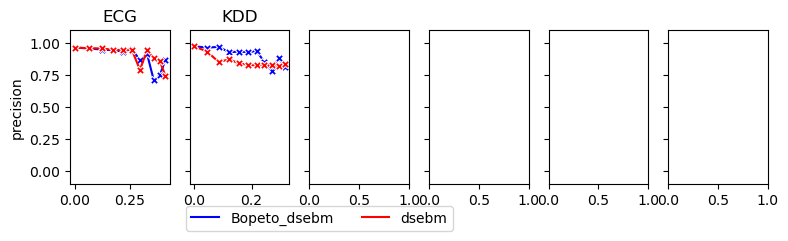

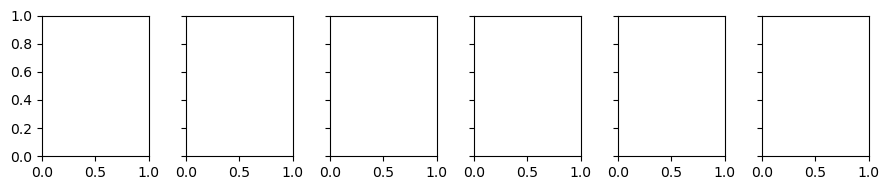

/tmp/ipykernel_278451/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


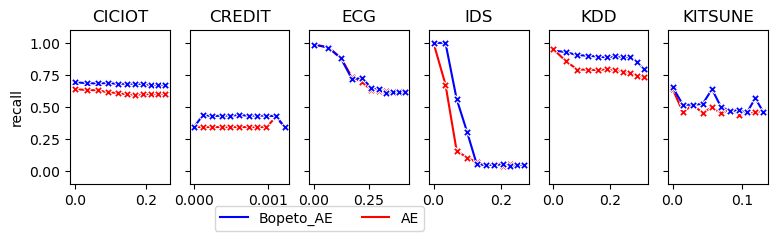

/tmp/ipykernel_278451/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


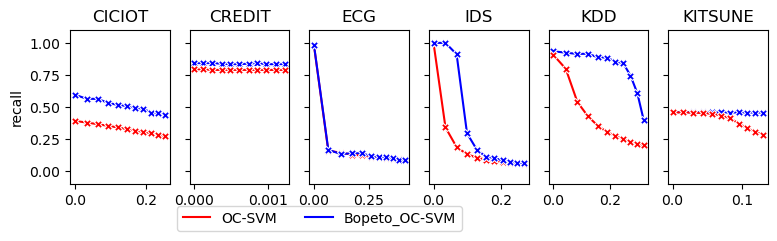

/tmp/ipykernel_278451/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


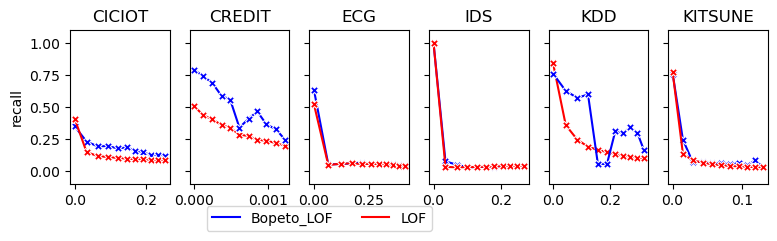

/tmp/ipykernel_278451/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


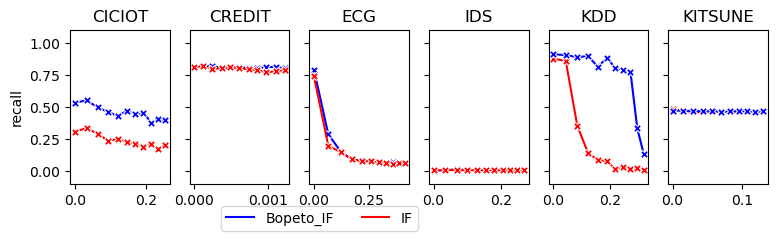

/tmp/ipykernel_278451/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


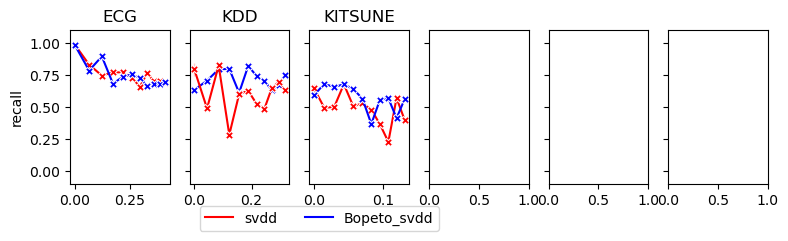

/tmp/ipykernel_278451/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


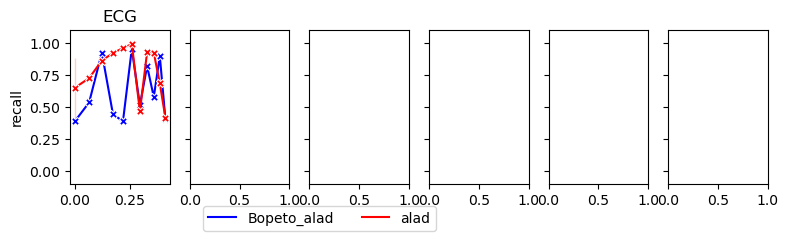

/tmp/ipykernel_278451/3230820549.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


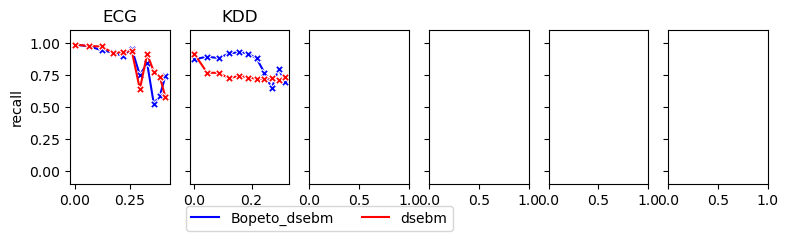

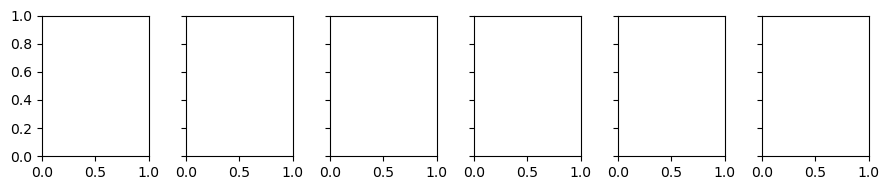

In [252]:
for metric in metrics:
    for model in models:
        palette ={'Bopeto_'+model: 'blue', model: 'red'}
        robustness = df_perf[df_perf['model'].str.contains(model)]
        robustness = robustness.sort_values(by='dataset')
        fig, axes = plt.subplots(ncols=6, figsize=(9, 2), sharey=True)
        for i, (ax, (subplot, df_group)) in enumerate(zip(axes, robustness.groupby('dataset'))):
            sns.lineplot(data=df_group, x=df_group.contamination, y=metric, hue='model', ax=ax, marker='X', palette=palette)
            ax.set_title(f'{subplot}'.upper())
            ax.set_xlabel('')
            if metric=="f1":
                ax.set_ylabel(r'F$_1$ score')
            else:
                ax.set_ylabel(metric)
            ax.set_ylim(-0.1, 1.1)

            if i != 0:
                ax.legend().remove()
            else:
                ax.legend(loc='lower center', bbox_to_anchor=(2.5, -0.35), ncol=2)
        plt.tight_layout()
        plt.savefig(model+"_"+metric+"_robustness.pdf")
        plt.show()

In [ ]:
df_group

In [634]:
dd_ecg = np.load("../data/ecg.npz", allow_pickle=True) 
dd_credit = np.load("../data/credit.npz", allow_pickle=True) 
data1_ecg = pd.DataFrame(dd_ecg['ecg'])
data1_credit = pd.DataFrame(dd_credit['credit'])

In [635]:
np.unique(data1_credit.values[:, -1])

array([0., 1.])

In [636]:
data1_kdd = pd.read_csv("kdd.csv")
data1_ids = pd.read_csv("ids.csv")
data1_ciciot = pd.read_csv("ciciot.csv")
data_kitsune = pd.read_csv("kitsune.csv")

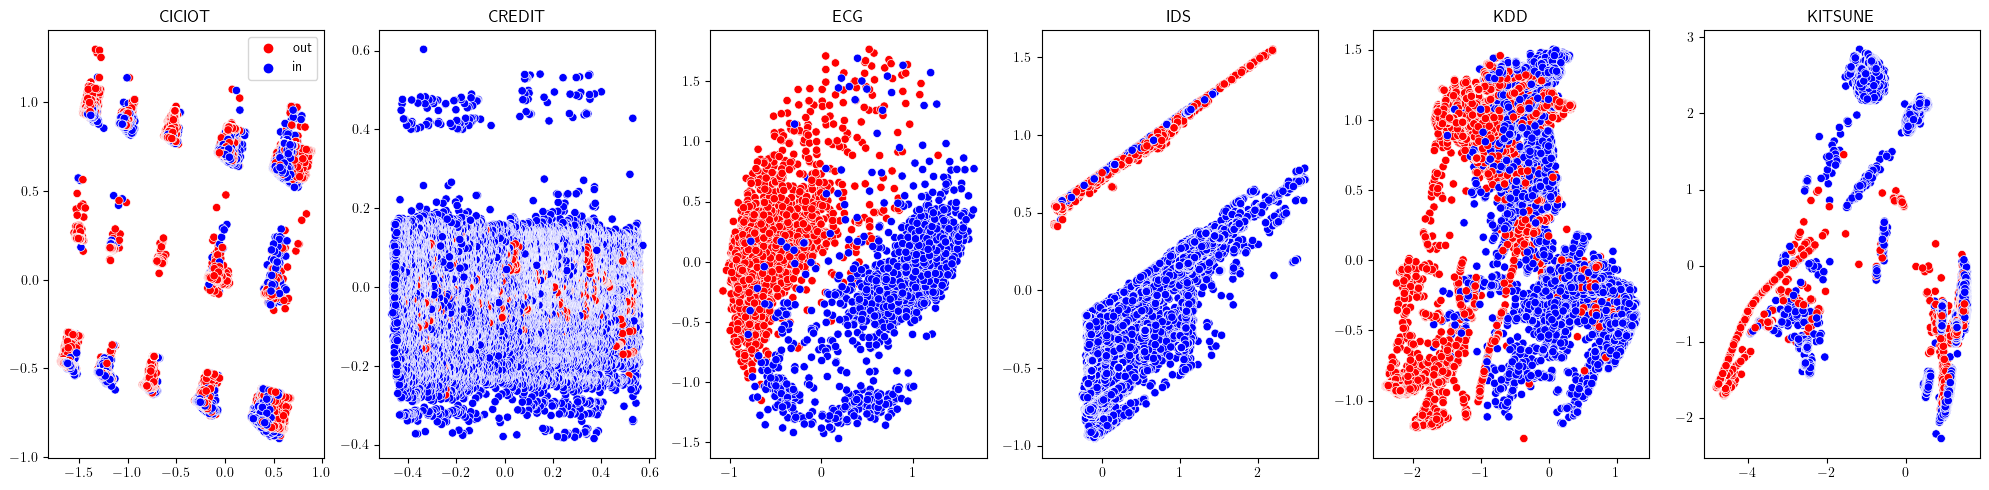

In [637]:

datasets = [data1_ciciot, data1_credit, data1_ecg, data1_ids, data1_kdd, data_kitsune]
pca = PCA(n_components=2)
fig, axs = plt.subplots(1, 6, figsize=(20, 5))
replacement_dict = {
    0: 'in',
    1: 'out',
    2: 'synthetic'
}
for i, xy in enumerate(datasets):
    
    x, y = xy.values[:, :-1], xy.values[:, -1]
    reduced_data = pca.fit_transform(x)
    df_pca = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
    df_pca['target'] = y
    df_pca['target'] = df_pca['target'].replace(replacement_dict)
    df_pca = df_pca[df_pca['target']!='synthetic']

    sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='target', ax=axs[i], palette={'in':'blue', 'out':'red', 'synthetic':'green'}, legend=(i==0))
    axs[i].set_title(names[i])
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    if i == 0:
        axs[i].legend(title='')
    else:
        axs[i].legend([],[], frameon=False)

plt.tight_layout()
plt.savefig("synthetic.png")
plt.show()


In [98]:
def sdc(dynamics):
    return np.std(np.diff(dynamics, axis=1), axis=1)

In [99]:
kdd_1 = np.loadtxt("kdd_FGM_sdc_ae_rate_0.18821442994855225.csv", delimiter=',')
ids_1 = np.loadtxt("ids_FGM_sdc_ae_rate_0.15585998801128825.csv", delimiter=',')
credit_1 = np.loadtxt("credit_FGM_sdc_ae_rate_0.0012223312434517968.csv", delimiter=',')
ecg_1 = np.loadtxt("ecg_FGM_sdc_ae_rate_0.21916092673763307.csv", delimiter=',')
ciciot_1 = np.loadtxt("ciciot_FGM_sdc_ae_rate_0.19310100024086915.csv", delimiter=',')
kitsune_1 = np.loadtxt("kitsune_FGM_sdc_ae_rate_0.0701628076642476.csv", delimiter=',')

In [100]:
x_kdd, y_kdd = kdd_1[:, :-1], kdd_1[:, -1]
x_ids, y_ids = ids_1[:, :-1], ids_1[:, -1]
x_ciciot, y_ciciot = ciciot_1[:, :-1], ciciot_1[:, -1]
x_kitsune, y_kitsune = kitsune_1[:, :-1], kitsune_1[:, -1]
x_credit, y_credit = credit_1[:, :-1], credit_1[:, -1]
x_ecg, y_ecg = ecg_1[:, :-1], ecg_1[:, -1]

In [159]:
m = 'score'
mac_kdd = sdc(x_kdd)
mac_ids = sdc(x_ids)
mac_ciciot = sdc(x_ciciot)
mac_kitsune = sdc(x_kitsune)
mac_credit = sdc(x_credit)
mac_ecg = sdc(x_ecg)

In [160]:
mapping = {0: 'in', 1: 'out', 2:'synthetic'}
def clean(dynamics, target, n=1000):
    detector = IsolationForest(n_estimators=50, random_state=42)
    df = pd.DataFrame(data = dynamics, columns=[m])
    df['class'] = target
    df['class'] = df['class'].replace(mapping)
    y_pred = detector.fit_predict(dynamics.reshape(-1, 1))
    anomaly_scores = detector.decision_function(dynamics.reshape(-1, 1))
    out = anomaly_scores[y_pred==-1]
    in_ = anomaly_scores[y_pred==1]
    threshold = (np.max(out)+np.min(in_))/2
    threshold = np.percentile(out, np.random.randint(60, 70, 1)[0])
    y_pred = anomaly_scores >= threshold

    df[m] = anomaly_scores
    y = y_pred==1
    sample = df.sample(n=n)
    selected = df.index.isin(sample.index)
    cleaned = df[y & selected].copy()
    return sample, cleaned, threshold 

In [161]:
all_data = [clean(mac_ciciot, y_ciciot), clean(mac_credit, y_credit), 
            clean(mac_ecg, y_ecg), clean(mac_ids, y_ids), 
            clean(mac_kdd, y_kdd), clean(mac_kitsune, y_kitsune)]


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


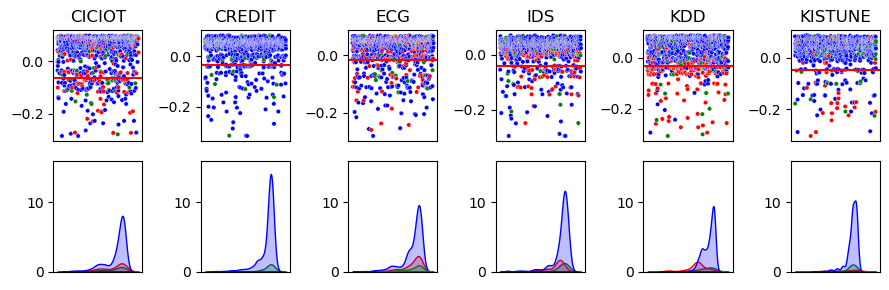

In [208]:
fig, axes = plt.subplots(2, 6, figsize=(9, 3))
datasets = ["CICIOT", "CREDIT", "ECG", "IDS", "KDD", "KISTUNE"]
palette = {"out":"red", "synthetic":"green", "in":"blue"}
for i, df in enumerate(all_data):
    for j in range(1):
        d = df[j]
        d = d.sort_index()
        ax = axes[0, i]
        sns.scatterplot(data=d, x=d.index, y=m, hue='class', ax=ax, palette=palette, s=10)
        ax.axhline(y=df[2], color='r', linestyle='-')
        ax.set_ylabel(None)
        if j==0:
            ax.set_title(datasets[i])
        if i!=0 or j!=1:
            ax.legend().remove()
        else:
            legend = ax.legend()
            if legend:
                for label in legend.get_texts():
                    label.set_fontsize('xx-small')
        
        
        ax.set_xticks([])
        ax = axes[1, i]
        sns.kdeplot(data= d, x='score', hue='class', fill=True, ax=ax, palette=palette)
        ax.legend().remove()
        ax.set_xticks([])
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        if i!=0:
            axes[0, i].set_ylabel('')
            axes[1, i].set_ylabel('')
        else:
            pass
            #axes[1, 0].set_ylabel('density')
        ax.set_ylim(0, 16)
plt.tight_layout()
plt.savefig("dynamics_space.png")
plt.show()

In [175]:
d

,score,class
54,-0.035615,in
136,-0.002366,out
249,0.087739,out
332,0.041645,in
579,0.088208,in
...,...,...
171680,0.089536,synthetic
172793,0.089479,in
172828,0.085978,in
172915,0.085347,out


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharey=True)
thresholds = [0.008, 0.015, 0.02]
for i, df in enumerate([df_kdd.sample(n=1000), df_ciciot.sample(n=1000), df_kitsune.sample(n=1000)]):
    ax = axes[i]
    sns.scatterplot(data=df, x=df.index, y=m, hue='class', ax=ax, palette=palette)
    ax.set_title(datasets[i])
    ax.axhline(y=thresholds[i], color='r', linestyle='-')
    if i!=0:
        ax.legend().remove()
    ax.set_xticks([])
plt.tight_layout()
plt.savefig("dynamics_space_threshold.png")
plt.show()


    

In [123]:
x_kdd.shape

(62647, 10)

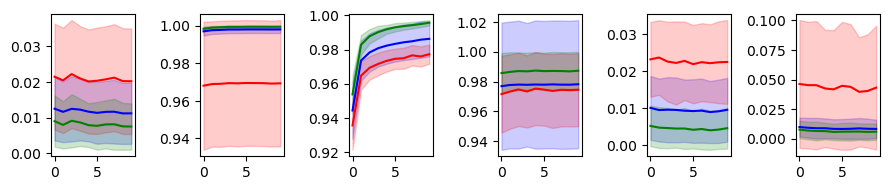

In [203]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data: 6 sequence matrices with three categories
num_matrices = 6
num_sequences = 100
sequence_length = 50
num_categories = 3

sequences = [x_ciciot, x_credit, x_ecg, x_ids, x_kdd, x_kitsune]
labels = [y_ciciot, y_credit, y_ecg, y_ids, y_kdd, y_kitsune]
colors = ['blue', 'red', 'green']
names = ['in', 'out', 'synthetic']
databases = ["CICIOT", "CREDIT", "ECG", "IDS", "KDD", "KITSUNE"]
fig, axs = plt.subplots(1, 6, figsize=(9, 2), sharex=True)
sequence_length = 10
for i in range(6):
    seq = sequences[i]
    lab = labels[i]
    for j in range(3):
        cat_sequences = seq[lab == j]
        mean_sequence = np.mean(cat_sequences, axis=0)
        std_sequence = np.std(cat_sequences, axis=0)
        axs[i].plot(mean_sequence, color=colors[j], label=names[j])
        axs[i].fill_between(range(sequence_length), mean_sequence - std_sequence, mean_sequence + std_sequence, color=colors[j], alpha=0.2)
        #axs[i].set_title(databases[i])



plt.tight_layout()
plt.savefig("dynamics_space_two.png")
plt.show()
